In [7]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from submodule_analysis import preprocess_snrna, grouped_obs_mean

In [4]:
snrna_dir = '../snrna/'
#snrna_file = os.path.join(snrna_dir, 'adata_U54_BA9_snrna_sennet.h5ad')
# Update with cluster assignments from Jason
snrna_file = os.path.join(snrna_dir, 'adata_U54_BA9_snrna_sennet_mapped_clusters.h5ad')

# Revert to raw counts
adata_sn = sc.read_h5ad(snrna_file)
if hasattr(adata_sn, 'raw'):
    adata_sn = adata_sn.raw.to_adata()
adata_sn.var.index = adata_sn.var['gene_name']

adata_sn = preprocess_snrna(adata_sn)

# Read module assignments and map to genes
module_file = 'U54_BA9_splotch_lambdas_corr_hclust_labels_d1700.csv'
df_modules = pd.read_csv(module_file, index_col=0)
df_modules.dropna(axis=0, inplace=True)

# Limit to set of genes in both tables (snRNA-seq, ST modules)
genes_shared = np.intersect1d(adata_sn.var.index.values, df_modules['gene_name'].values)
df_modules = df_modules.loc[df_modules['gene_name'].isin(genes_shared), :]
adata_sn = adata_sn[:, genes_shared]

/Volumes/Aidan_NYGC/Visium/U54_BA9/coexpression_analysis/submodule_analysis.py:33: FutureWarning: The specified parameters ('target_sum',) are no longer positional. Please specify them like `target_sum=1000000.0`
  adata_pp = sc.pp.normalize_total(adata, 1e6, copy=True)    # TPM normalization


In [214]:
# For a given geneset, find subclusters associated with given cell type annotations in snRNA-seq data
def plot_submodules(adata, geneset, obs_ctype, vmax=None, min_genes=10, display_genes=None):
	df_means = grouped_obs_mean(adata[:, geneset], obs_ctype)

	# Normalize gene expression between 0 and 1 across cell types
	df_means = df_means / df_means.max(axis=1).values[:, None] 

	# Determine cluster membership by distance cutoff
	Z = linkage(df_means.values, method='average', metric='cosine')
	max_d = 0.54 * max(Z[:,2])
	clusters = fcluster(Z, max_d, criterion='distance')

	# Map all clusters with >min_genes to a Tab20 color; all others to white.
	k = len(np.unique(clusters))
	cmap = plt.get_cmap('tab20')
	cNorm = colors.Normalize(vmin=0, vmax=20)
	scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
	k2col = [scalarMap.to_rgba(np.remainder(i, 20)) if np.sum(clusters==i+1) > min_genes else (1,1,1,1) for i in range(k)]
    
	figsize=(10,10)
	bottom = 0.25

	# Render mean expression as a heatmap with rows grouped (and colored) by subcluster
	if vmax is None:
		vmax = df_means.values.max()
	cg = sns.clustermap(df_means, method='average', metric='cosine',
				   row_cluster=True, row_linkage=Z, row_colors=[k2col[i-1] for i in clusters],
				   col_cluster=False,
				   vmin=0, vmax=vmax,
				   figsize=figsize,
				   cmap='Greys',
				   cbar_kws={'orientation':'horizontal'})
	cg.ax_heatmap.set_xticks(np.arange(len(df_means.columns))+0.5)
	cg.ax_heatmap.set_xticklabels(df_means.columns, fontsize = 16)
	cg.figure.subplots_adjust(bottom=bottom)

    # Reduce number of genes shown so we can increase font size
	if display_genes is not None:
		row_inds_ordered = cg.dendrogram_row.reordered_ind
		row_genes_ordered = df_means.index[row_inds_ordered]
		yticks = [list(row_genes_ordered).index(g)+0.5 for g in display_genes]
		sort_inds = np.argsort(yticks)
		yticks = np.array(yticks)[sort_inds]
		yticklabels = np.array(display_genes)[sort_inds]
		ytl = []
		for i, (y,g) in enumerate(zip(yticks, yticklabels)):
			ytl.append(g)
			if i > 0 and np.abs(yticks[i-1]-y) < 30:
				ytl[i] += ', ' + ytl[i-1]
				ytl[i-1] = ''
		cg.ax_heatmap.set_yticks(yticks)
		cg.ax_heatmap.set_yticklabels(ytl, fontsize=14)
		print(yticks, yticklabels)
	else:
		cg.ax_heatmap.set_yticks([])
	cg.ax_heatmap.set_ylabel('')
    
	x0, _y0, _w, _h = cg.cbar_pos
	cg.ax_cbar.set_position([x0, 0.9, cg.ax_row_dendrogram.get_position().width+0.05, 0.02])
	cg.ax_cbar.set_title('Scaled mean expression', fontsize=14)
	cg.ax_cbar.tick_params(axis='x', length=10)
	for t in cg.ax_cbar.get_xticklabels():
		t.set_fontsize(14)

	df_label = pd.DataFrame({'submodule': clusters}, index=df_means.index)

	# Re-label all submodules s.t. only those with >min_genes receive an index; all others are NaN
	smod_cnt = 0
	for lbl in sorted(df_label['submodule'].unique()):
		inds = df_label['submodule']==lbl
		if np.sum(inds) > 10:
			smod_cnt += 1
			df_label.loc[inds, 'submodule'] = str(smod_cnt)
		else:
			df_label.loc[inds, 'submodule'] = ''

	return cg, df_label

In [215]:
mset = 'd1700'
plot_dir = 'submodules'
obs_ctype = 'mapped_cluster'
m = 1

[  30.5   83.5  141.5  167.5  349.5  352.5  353.5  354.5  365.5  399.5
 1888.5 1928.5 1931.5 1932.5] ['PDGFRA' 'TIMP1' 'PECAM1' 'HEG1' 'MAG' 'CNP' 'MBP' 'PLP1' 'MOBP' 'MOG'
 'CD68' 'C1QA' 'AIF1' 'TYROBP']


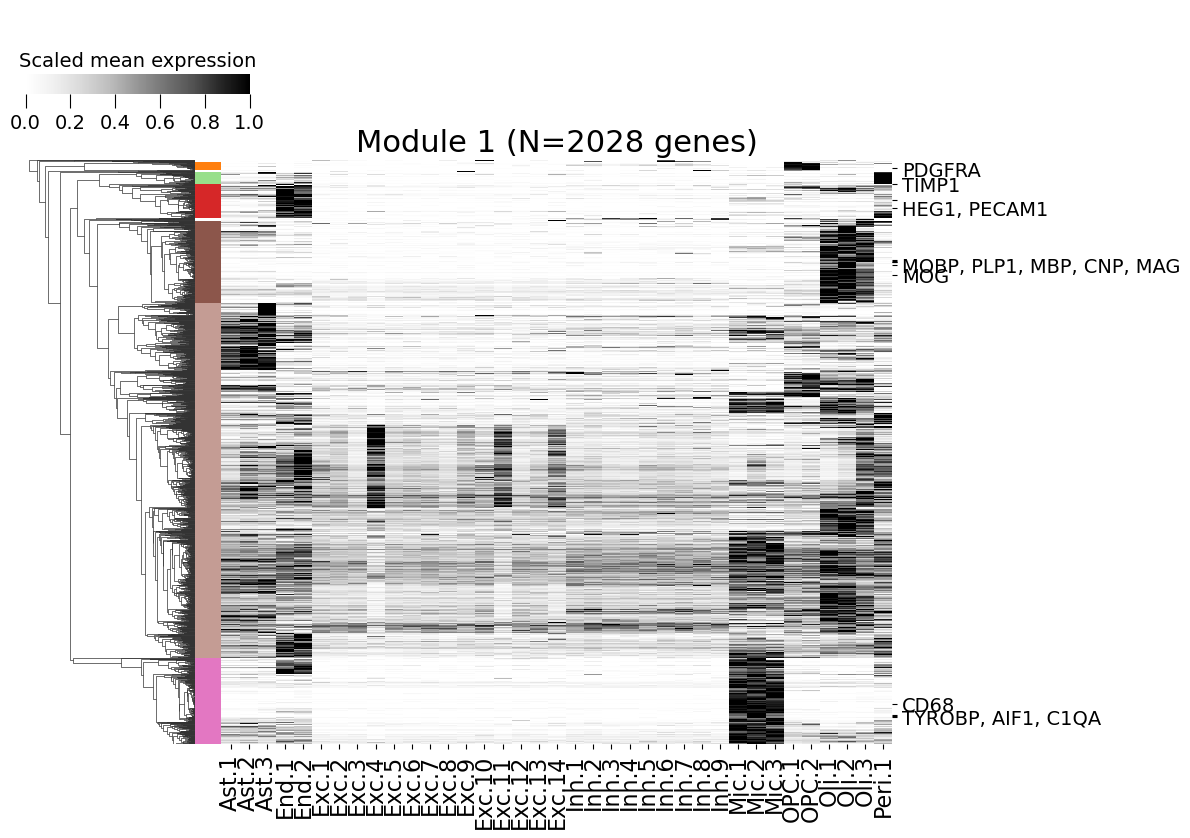

In [216]:
genes_m = df_modules['gene_name'][df_modules[mset]==m]
if len(genes_m) > 10:
    if m==1:
        display_genes = ['PDGFRA', 'TIMP1', 'PECAM1', 'HEG1', 'MOG', 'MOBP', 
                         'PLP1', 'MBP', 'CNP', 'MAG', 'AIF1', 'TYROBP', 'CD68', 'C1QA']
    
    g, df_label = plot_submodules(adata_sn, genes_m, obs_ctype=obs_ctype, display_genes=display_genes)
    g.ax_heatmap.set_title('Module %d (N=%d genes)' % (m, len(genes_m)), fontsize=22)
    plt.savefig('module1_tmp.png', dpi=300, bbox_inches='tight')

In [84]:
adata_sn.var

,gene_name
gene_name,
A1BG,A1BG
A2M,A2M
AAAS,AAAS
AACS,AACS
AADAT,AADAT
...,...
ZXDB,ZXDB
ZXDC,ZXDC
ZYG11B,ZYG11B
